# Build MLP Classifier Models

## Import Processed Data

In [1]:
import pandas as pd
from pathlib import Path
import numpy as np
from sklearn.externals import joblib
from sklearn.decomposition import PCA
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV

In [2]:
# set path of the processed data
processed_data_path = Path.cwd().parent / 'data' / 'processed'
train_processed_file_path = processed_data_path /'train_processed.csv'
test_processed_file_path = processed_data_path / 'test_processed.csv'
unlabeled_processed_file_path = processed_data_path / 'unlabeled_processed.csv'

# create data frames for train, test, and unlabled data
train_df = pd.read_csv(train_processed_file_path, index_col = 'ImageId')
test_df = pd.read_csv(test_processed_file_path, index_col = 'ImageId')
unlabeled_df = pd.read_csv(unlabeled_processed_file_path, index_col = 'ImageId')

In [3]:
# in the train and test data, X contains all the columns except 'label'
# y is 'label'
X_train = train_df.drop(['label'], axis = 1)
y_train = train_df['label']
X_test = test_df.drop(['label'], axis = 1)
y_test = test_df['label']

## PCA

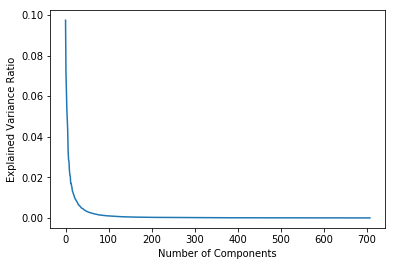

In [4]:
# let's look at how explained variance ratio varies with number of components
import matplotlib.pyplot as plt
%matplotlib inline

pca = PCA(random_state = 42)
pca.fit(X_train)

plt.plot(pca.explained_variance_ratio_)
plt.xlabel('Number of Components')
plt.ylabel('Explained Variance Ratio')
plt.show()

In [5]:
# it looks like we can get away with using about 50 components
pca = PCA(n_components = 50,
          random_state = 42).fit(X_train)
X_train_pca = pca.transform(X_train)
X_test_pca = pca.transform(X_test)
unlabeled_pca = pca.transform(unlabeled_df)

## Default MLP Classifier (with PCA)

In [6]:
# use 5-fold CV to evaluate accuracy with pca-train data
model = MLPClassifier(random_state = 42)
scores = cross_val_score(model, X_train_pca, y_train, cv = 5)

print('CV accuracty mean: ' + '{0:2f}'.format(scores.mean()))
print('CV accuracty std: ' + '{0:2f}'.format(scores.std()))
print('CV scores:', scores)

CV accuracty mean: 0.971667
CV accuracty std: 0.002206
CV scores: [0.96981413 0.97559887 0.96948951 0.97112236 0.97230907]


In [7]:
# fit model to entire train set
model = MLPClassifier(random_state = 42).fit(X_train_pca, y_train)

# evaluate accuracy on test set
print('Default MLP (w/PCA) Accuracy: ' + '{0:2f}'.format(model.score(X_test_pca, y_test)))

Default MLP (w/PCA) Accuracy: 0.974286


## Tuned MLP Classifier (with PCA)

Once again, a decent search takes too long on my laptop, so I did several batches "by hand."

In [19]:
# define the parameter values that will be considered
sizes = [(400,), (300, 100,)]
params = {'hidden_layer_sizes' : sizes}

# used to evaluate all possible combinations with 5-fold cross-validation
grid_search = GridSearchCV(MLPClassifier(random_state = 42),
                           param_grid = params,
                           cv = 5,
                           refit = True,
                           return_train_score = True)

# fit
grid_search.fit(X_train_pca, y_train)

# return the optimal combo of parameters and its score
print(grid_search.best_params_, '\n')
print(grid_search.best_score_)

{'hidden_layer_sizes': (400,)} 

0.9787797619047619


In [20]:
# use 5-fold CV to evaluate accuracy with pca-train data
model = MLPClassifier(random_state = 42,
                      hidden_layer_sizes = (400,))
scores = cross_val_score(model, X_train_pca, y_train, cv = 5)

print('CV accuracty mean: ' + '{0:2f}'.format(scores.mean()))
print('CV accuracty std: ' + '{0:2f}'.format(scores.std()))
print('CV scores:', scores)

CV accuracty mean: 0.978779
CV accuracty std: 0.001771
CV scores: [0.97947955 0.98169915 0.97633576 0.97811849 0.97826411]


## Kaggle Score: 0.97928

Before we "go live" with this model (that is, submit its predictions to Kaggle), let's check how it performs on the test data, data that it has never seen and had no influence on its selection:

In [21]:
# fit model to entire train set
model = MLPClassifier(random_state = 42,
                      hidden_layer_sizes = (400,)).fit(X_train_pca, y_train)

# evaluate accuracy on test set
print('Tuned MLP (w/PCA) Accuracy: ' + '{0:2f}'.format(model.score(X_test_pca, y_test)))

Tuned MLP (w/PCA) Accuracy: 0.979881


Looks good, make the submission to Kaggle.

In [22]:
# generate predictions
predictions = model.predict(unlabeled_pca)

# create a new data frame with two columns: ImageId and our predicted values for 'label'
submission_df = pd.DataFrame({'ImageId' : unlabeled_df.index, 'label' : predictions})

# write submission to disk...
# first define path
submission_file_path = Path.cwd().parent / 'data' / 'external' / 'mlp_with_pca.csv'

# create the .csv file
# index is False since we don't want a third column
submission_df.to_csv(submission_file_path, index = False)

## Model Persistence

In [23]:
# Note: the PCA tool was persisted in the KNN notebook, so no need to do it again

# create file paths
model_file_path = Path.cwd().parent / 'models' / 'mlp_model.pkl'

# persist the model and pca
joblib.dump(model, model_file_path);

#### Optional: Check the persisted model

In [24]:
# create file paths
pca_file_path = Path.cwd().parent / 'models' / 'pca_50.pkl'
model_file_path = Path.cwd().parent / 'models' / 'mlp_model.pkl'

# load
pca_loaded = joblib.load(pca_file_path)
model_loaded = joblib.load(model_file_path)

In [25]:
# print the model object description
model_loaded

MLPClassifier(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(400,), learning_rate='constant',
       learning_rate_init=0.001, max_iter=200, momentum=0.9,
       nesterovs_momentum=True, power_t=0.5, random_state=42, shuffle=True,
       solver='adam', tol=0.0001, validation_fraction=0.1, verbose=False,
       warm_start=False)

In [26]:
# print the pca object description
pca_loaded

PCA(copy=True, iterated_power='auto', n_components=50, random_state=42,
  svd_solver='auto', tol=0.0, whiten=False)

In [27]:
# transform the test data using loaded pca object
X_test_pca = pca_loaded.transform(X_test)

# calculate the score using the loaded model object
# we should get 0.979881, as above
print('Persisted MLP (w/PCA) Accuracy: ' + '{0:2f}'.format(model_loaded.score(X_test_pca, y_test)))

Persisted MLP (w/PCA) Accuracy: 0.979881


## Error Analysis

In [29]:
# imports
from sklearn.model_selection import cross_val_predict

In [30]:
# instead of scoring, get the cross-validated estimates for each image
y_train_pred = cross_val_predict(model, X_train_pca, y_train, cv = 5)

In [31]:
# now let's take a look at the confusion matrix to see
# which actual labels (rows) do not match the predicted label (columns)
from sklearn.metrics import confusion_matrix

conf_mx = confusion_matrix(y_train, y_train_pred)
print(np.matrix(conf_mx))

[[3267    1    2    2    1    5   13    2   11    2]
 [   0 3707   10    3    6    0    2    8   10    1]
 [   6    6 3273   10    9    0    4   17   13    4]
 [   4    2   28 3379    0   28    1    7   19   13]
 [   4    7    6    2 3182    3   15    6    3   30]
 [   5    2    3   25    1 2963   14    3   10   10]
 [  12    2    5    0    8   13 3265    0    4    0]
 [   7   10   24    5    6    1    1 3440    5   22]
 [   4   10   14   17    7   10    5    7 3159   17]
 [   8    2    5   14   27    8    4   20   10 3252]]


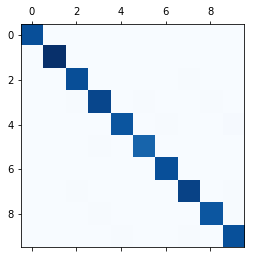

In [32]:
# color-coding might be easier to look at than a bunch of numbers:
# the darker, the bigger the value; the whiter, the smaller the value
plt.matshow(conf_mx, cmap = plt.cm.Blues);

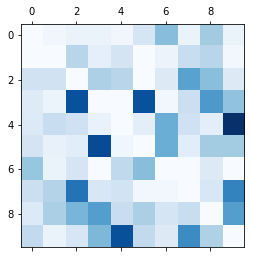

In [33]:
# well, this just confirms that the model is very accurate, which we already know...
# let's look at error rates by dividing by the number of images in each label (row sum)
row_sums = conf_mx.sum(axis = 1, keepdims = True)
norm_conf_mx = conf_mx / row_sums

# we only want errors, so let's fill the diagonal with zeros
np.fill_diagonal(norm_conf_mx, 0)

# plot
plt.matshow(norm_conf_mx, cmap = plt.cm.Blues);

As with the other models we've considered, the biggest problem is that many 4s are mislabeled as 9s. The following are pairs that are mislabeled in both directions: 4s and 9s, 7s and 9s, 3s and 9s, 3s and 8s, 2s and 7s, and 3s and 5s.

Other problems: 8s are mislabeled as 9s, and 3s are mislabeled as 2s.

Remedies include those mentioned in the KNN notebook. However, I think I might instead build a few more classifiers, then use ensemble techniques to (hopefully) increase accuracy beyond the current high score (0.98200).